# Projeto 1: Interpretabilidade de modelos

1. Escolha uma base de dados do seu interesse e construa ou reuse modelos preditivos.

2. Trabalhe agora com os aspectos de interpretabilidade principais explorados em sala. 
   - Discuta o que o modelo aprendeu de uma forma global: como ele realiza suas predições, quais as variáveis mais importantes,... dentre outros aspectos que ajude a entender o comportamento do modelo enquanto realiza suas predições. Técnicas sugeridas: global surrogates, Feature Importance e PDPs. 
    - Aplique métodos de explicação local para instâncias de interesse. Sugestões de técnicas: LIME, Shap, Contrafactuais. 

Obs.: escolha pelo menos duas técnicas globais e duas locais.

Obs.: a entrega será feita como um notebook ou relatório comentando os insights obtidos. Mais que gerar gráficos e estatísticas, é importante que se analise os resultados obtidos e que se apontem as conclusões mais importantes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utils import *

/home/pbsl/pog/proj-TAIC-2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
experiment_name = getExpName('airbnb')

models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True)

b317a82ec7104fea86e83c17225a197f


08929889bc8d4fbba7d140df3d10372a


e4b72507c4b746a1bb5cbed3e263ff40


In [3]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data()

In [23]:
from sklearn.inspection import permutation_importance

def pfi(model, x, y, name=None):
  result = permutation_importance(model, x, y,n_repeats=30, random_state=int(os.getenv('SEED')))

  cols = [f"[{i}] - {x.columns[i]}" for i in range(len(x.columns))]

  importances = pd.Series(result.importances_mean, index=cols)

  #plt.rcParams.update({'font.size': 5})
  fig, ax = plt.subplots(figsize=(18,9))

  importances.plot.bar(yerr=result.importances_std, ax=ax)

  if(name):
    ax.set_title(f"Feature importances on {name} model")
  else:
    name = str(model)
    i = name.find('(')
    ax.set_title(f"Feature importances on {name[:i]} model\n{name[i:]}")#, fontsize=10)
  ax.set_ylabel("Mean accuracy decrease", fontsize=12)
  plt.xticks(rotation=85, fontsize=9)
  #fig.tight_layout()
  plt.show()
  return result

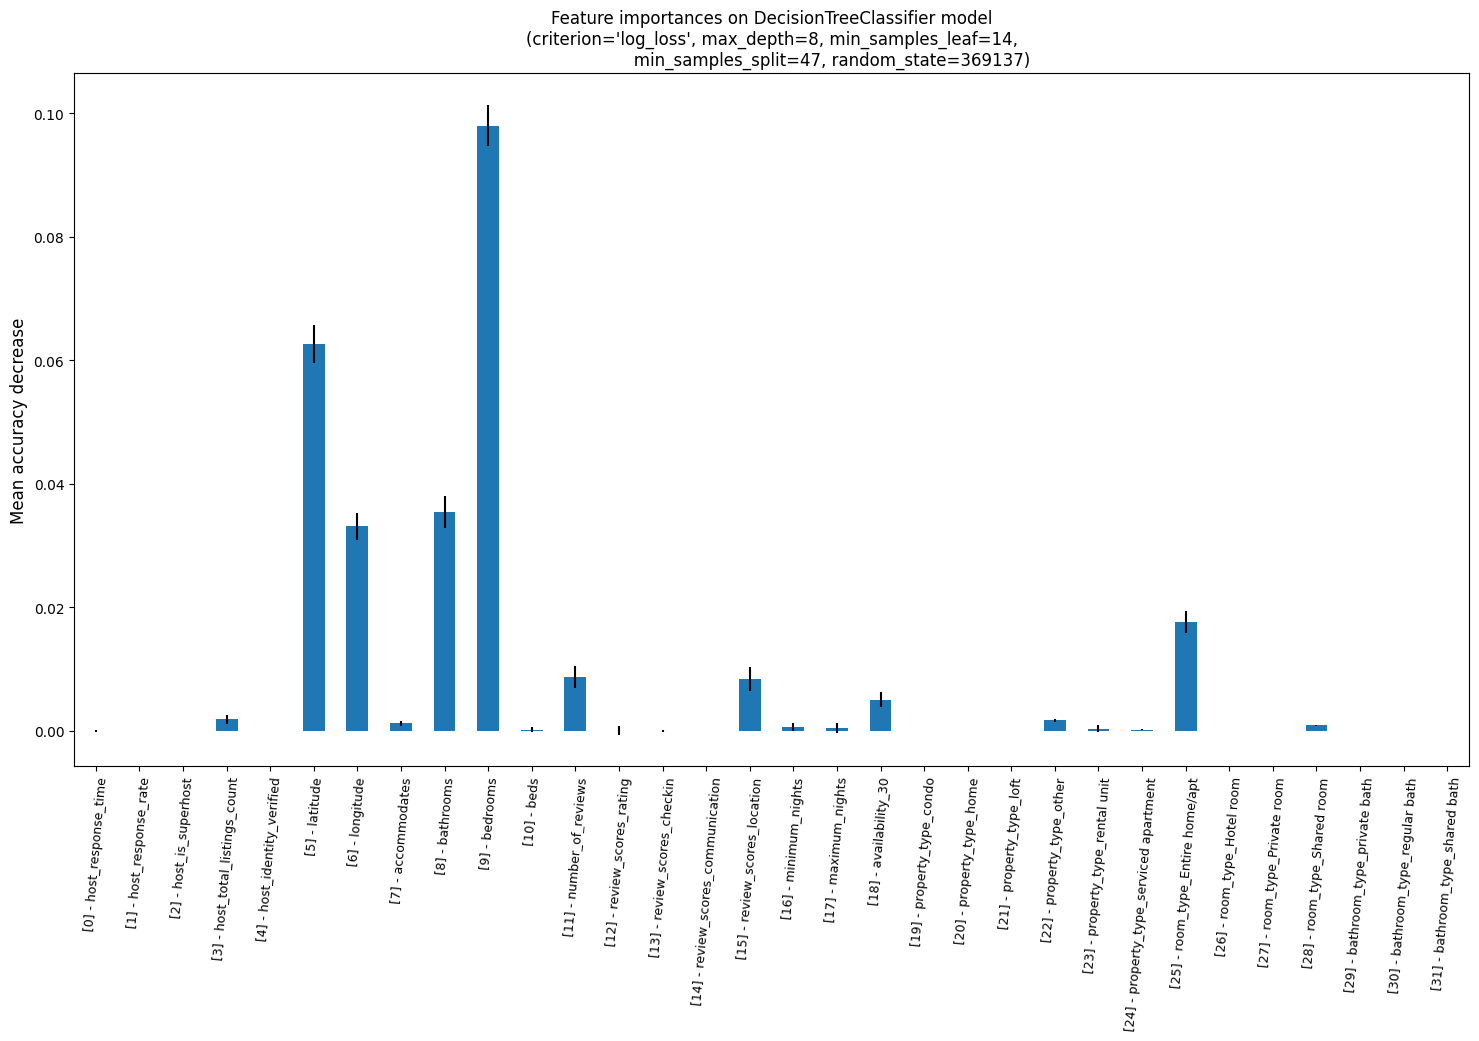

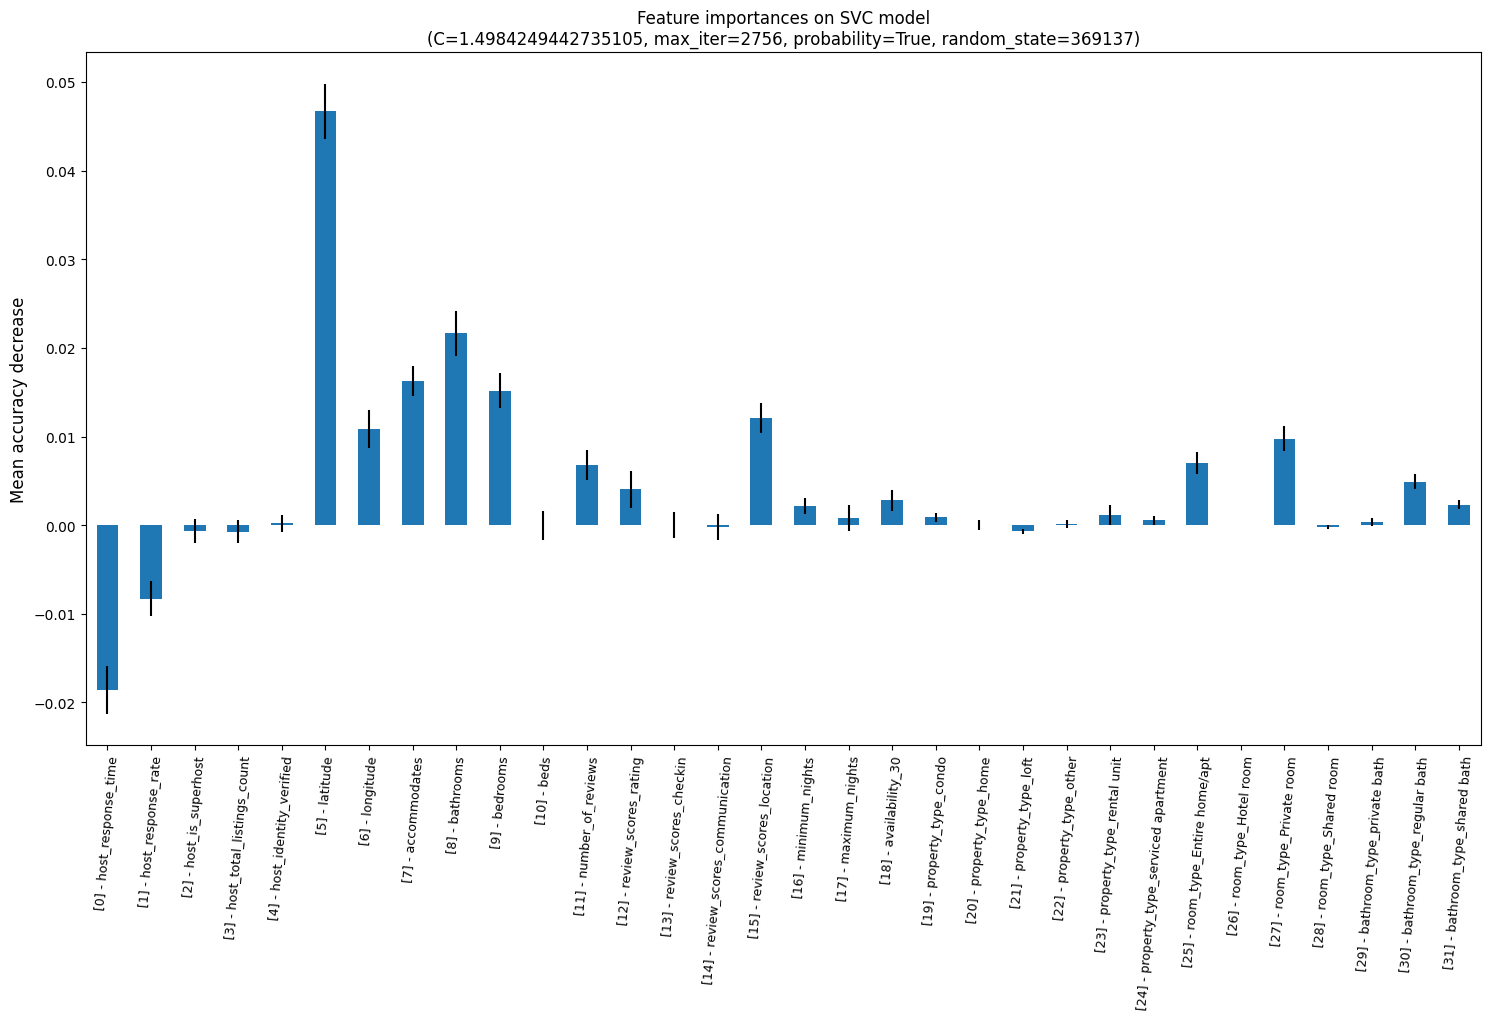

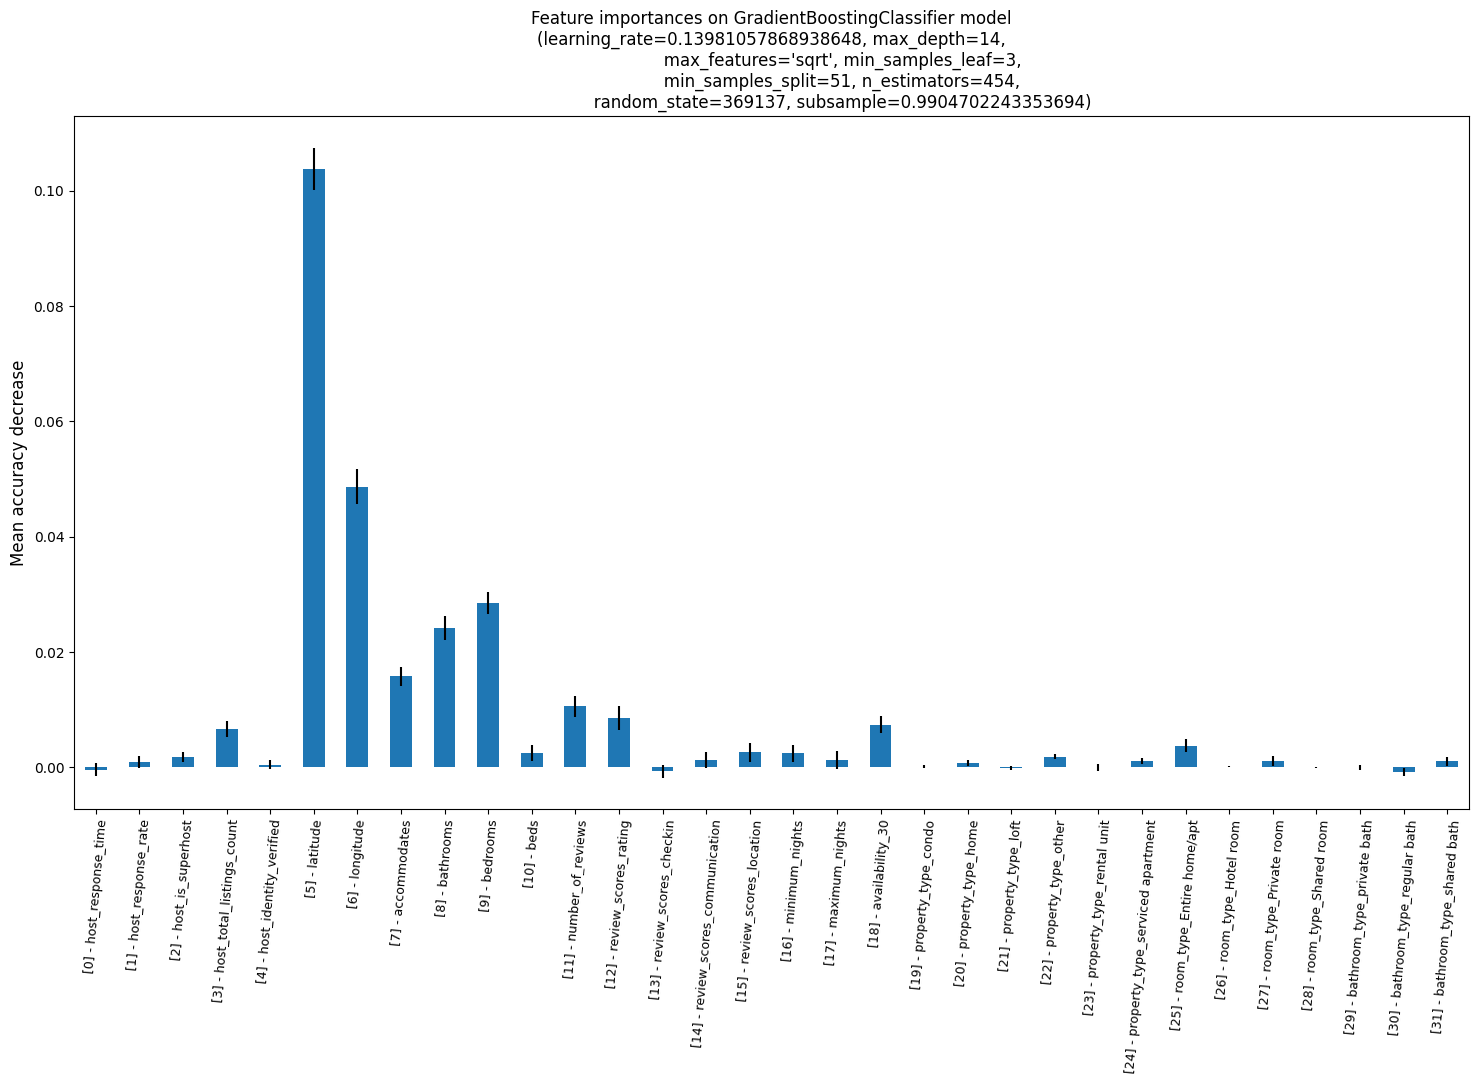

In [24]:
dtree_pfi = pfi(models['Decision_Tree'], X_test, y_test)

svm_pfi = pfi(models['SVM_RBF'], X_test_norm, y_test)

gb_pfi = pfi(models['Grandient_Boosting'], X_test, y_test)

In [44]:
from sklearn.inspection import PartialDependenceDisplay as pdp
display_labels = X_train.columns

def pdpClasses(model, x, features: list, res: int = 10, classes: list=[1]):
  global display_labels
  for idx in classes:
    pdp.from_estimator(model, x, features, target=idx, grid_resolution=res)
  plt.show()

def pdp2versions(model_list: list | tuple, x_list: list | tuple, features: list, res: int = 10, axis:int=0):
  if(axis==0):
    for idx in features:
      for i, (model, xt) in enumerate(zip(model_list, x_list)):
        name = str(model)
        print(f'\n{name[:name.find("(")]} {i+1}:')
        if(len(xt.columns) != 1):
          pdpClasses(model=model, x=xt, features=[idx], res=res)
        else:
          pdpClasses(model=model, x=xt, features=[0], res=res)
      print('\n'+"-"*60+'\n'+"-"*60)
  elif(axis==1):
    for i, (model, xt) in enumerate(zip(model_list, x_list)):
      name = str(model)
      print(f'\n{name[:name.find("(")]} {i+1}:')
      for idx in features:
        if(len(xt.columns) != 1):
          pdpClasses(model=model, x=xt, features=[idx], res=res)
        else:
          pdpClasses(model=model, x=xt, features=[0], res=res)
      print('\n'+"-"*60+'\n'+"-"*60)
  else:
    print('axis deve ser igual a 0 ou 1')

In [40]:
np.abs(dtree_pfi.importances_mean).argmax()

np.int64(9)

In [ ]:
pdp2versions()

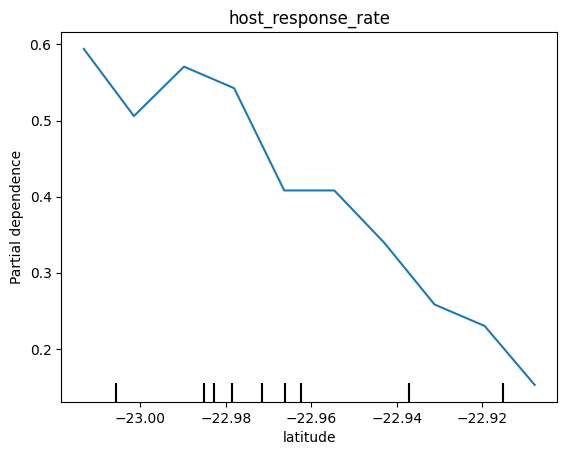

In [41]:
pdpClasses(models['Decision_Tree'], X_train, [5])

In [28]:
list(models.values())

[DecisionTreeClassifier(criterion='log_loss', max_depth=8, min_samples_leaf=14,
                        min_samples_split=47, random_state=369137),
 SVC(C=1.4984249442735105, max_iter=2756, probability=True, random_state=369137),
 GradientBoostingClassifier(learning_rate=0.13981057868938648, max_depth=14,
                            max_features='sqrt', min_samples_leaf=3,
                            min_samples_split=51, n_estimators=454,
                            random_state=369137, subsample=0.9904702243353694)]

In [46]:
[int(np.abs(x_pfi.importances_mean).argmax()) for x_pfi in [dtree_pfi, svm_pfi, gb_pfi]]

[9, 5, 5]


DecisionTreeClassifier 1:


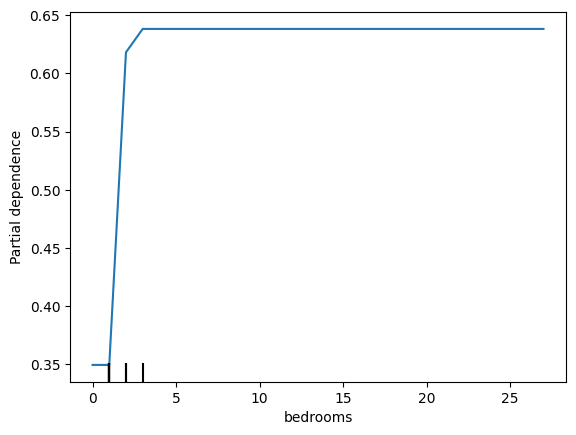


SVC 2:


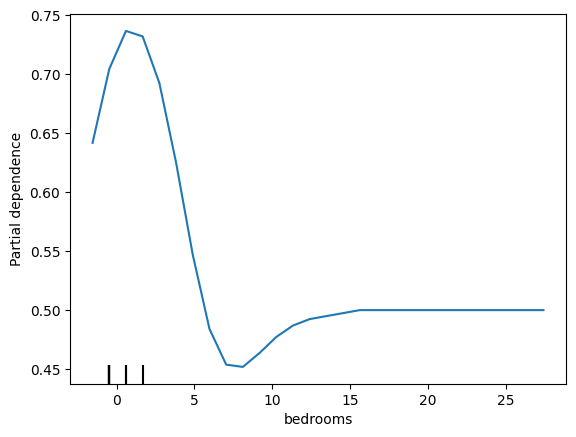


GradientBoostingClassifier 3:


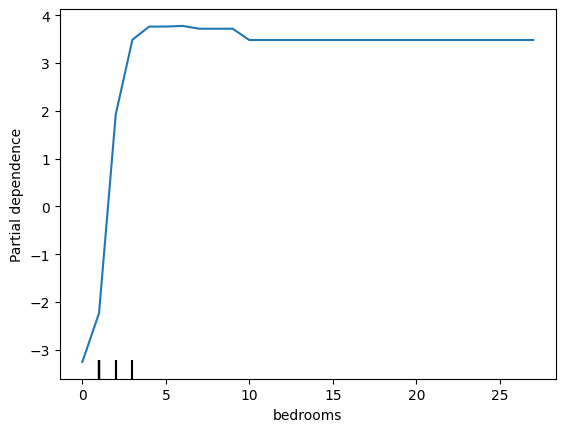


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


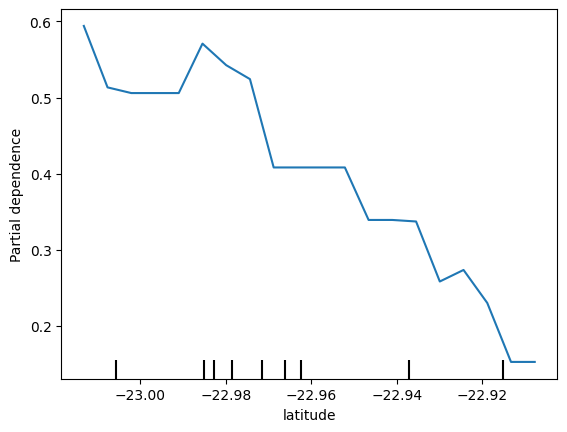


SVC 2:


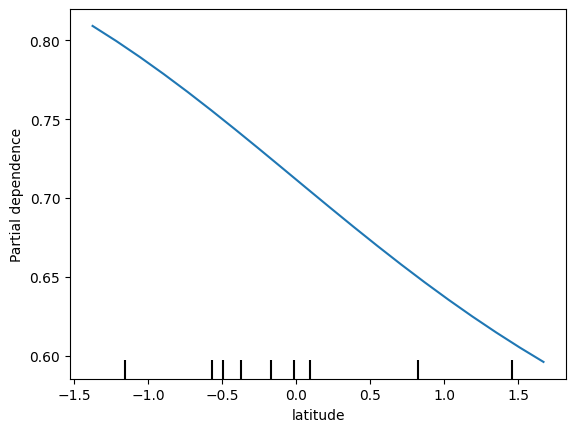


GradientBoostingClassifier 3:


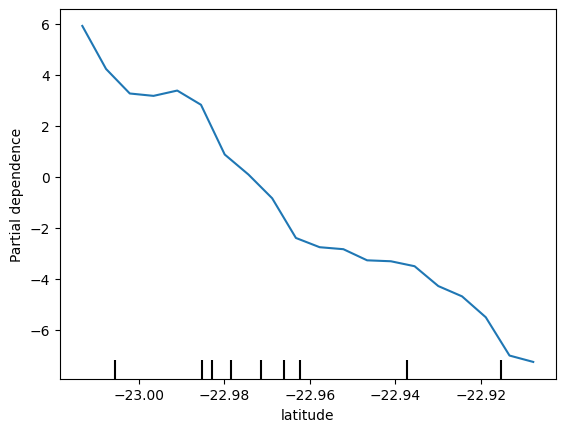


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


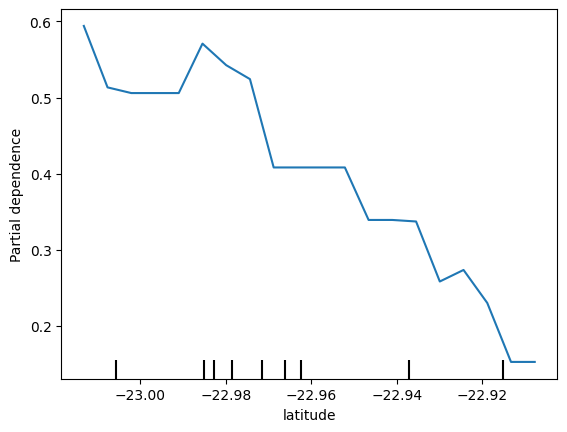


SVC 2:


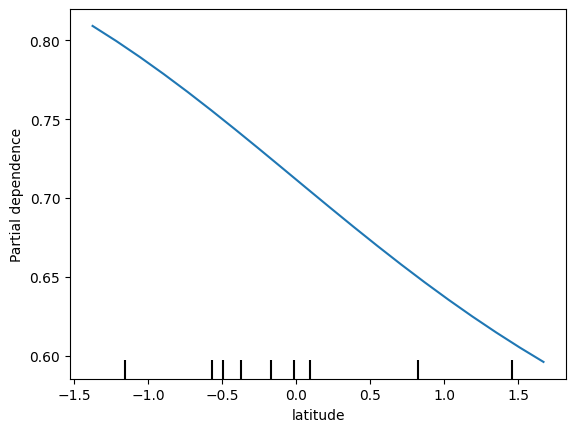


GradientBoostingClassifier 3:


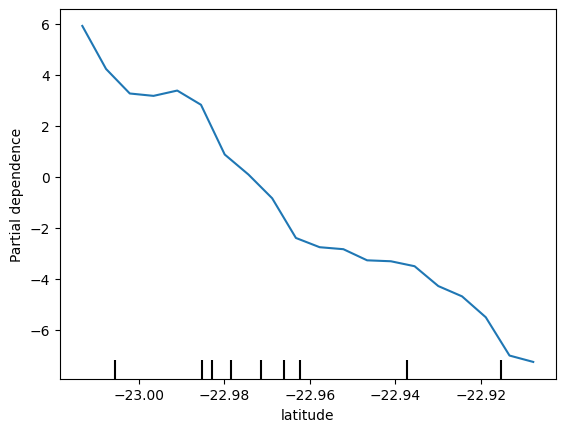


------------------------------------------------------------
------------------------------------------------------------


In [47]:
chosen_features = [np.abs(x_pfi.importances_mean).argmax() for x_pfi in [dtree_pfi, svm_pfi, gb_pfi]]
pdp2versions(list(models.values()), (X_train, X_train_norm, X_train), chosen_features, 20)